# Project - ECG Arrhythmia Classification
### Natalia Kolińska, Alicja Smaruj, Dorota Woźna, Kacper Zielak


## Imports

In [1]:
#pip install -r requirements.txt

In [69]:
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from scikit_posthocs import posthoc_dunn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from util import *
import warnings

c:\users\alicj\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Load data
Source: [Kaggle](https://www.kaggle.com/datasets/sadmansakib7/ecg-arrhythmia-classification-dataset?select=Sudden+Cardiac+Death+Holter+Database.csv)

In [3]:
df_1 = pd.read_csv("data/INCART 2-lead Arrhythmia Database.csv")
df_2 = pd.read_csv("data/MIT-BIH Arrhythmia Database.csv")
df_3 = pd.read_csv("data/MIT-BIH Supraventricular Arrhythmia Database.csv")
df_4= pd.read_csv("data/Sudden Cardiac Death Holter Database.csv")

c:\users\alicj\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
all_data = pd.concat([df_1, df_2, df_3, df_4])
all_data.head()

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,I01,N,163.0,165.0,0.069610,-0.083281,0.614133,-0.392761,0.047159,15.0,...,-0.023370,14.0,3.0,23.0,6.0,-0.023370,-0.011650,0.082608,0.101373,-0.183387
1,I01,N,165.0,166.0,-0.097030,0.597254,-0.078704,-0.078704,-0.137781,3.0,...,0.081637,15.0,5.0,27.0,7.0,0.081637,0.102992,0.191225,0.217544,-0.068248
2,I01,N,166.0,102.0,0.109399,0.680528,-0.010649,-0.010649,-0.720620,6.0,...,-0.148539,33.0,13.0,52.0,6.0,-0.148539,-0.060620,0.081080,0.204400,0.335172
3,I01,VEB,102.0,231.0,0.176376,0.256431,-0.101098,-0.707525,-0.101098,4.0,...,0.046898,21.0,9.0,34.0,4.0,0.046898,0.083728,0.279512,0.526785,0.450969
4,I01,N,231.0,165.0,0.585577,0.607461,-0.083499,-0.083499,-0.167858,3.0,...,-0.112552,32.0,5.0,43.0,6.0,-0.112552,0.012989,0.091491,0.134004,0.265232


In [5]:
all_data.shape

(963654, 34)

## Explore data

Dependent variable
- N (Normal),
- SVEB (Supraventricular ectopic beat),
- VEB (Ventricular ectopic beat),
- F (Fusion beat),
- Q (Unknown beat).

In [6]:
all_data.groupby("type").size()

type
F         1256
N       809352
Q         6620
SVEB     18540
VEB      51669
dtype: int64

The dataset contains features created from cardiac ECG results. The heights or widths calculated between specific moments in the time series are given. This allows the use of machine learning for time series classification.

<img src="images/wykres_ecg.png" alt="Wykres" width="400"/>
<img src="images/prepost.png" alt="Wykres2" width="400"/>

The authors of the collection created 16 variables. They examined them on raw time series (a) and processed series on which noise was removed (b). Hence, 32 columns of measurements. The raw data are prefixed '0' and the processed data '1'.



<img src="images/LeadAB.png" alt="Wykres2" width="800"/>

### Null values

In [7]:
all_data.isnull().any()

record            True
type              True
0_pre-RR          True
0_post-RR         True
0_pPeak           True
0_tPeak           True
0_rPeak           True
0_sPeak           True
0_qPeak           True
0_qrs_interval    True
0_pq_interval     True
0_qt_interval     True
0_st_interval     True
0_qrs_morph0      True
0_qrs_morph1      True
0_qrs_morph2      True
0_qrs_morph3      True
0_qrs_morph4      True
1_pre-RR          True
1_post-RR         True
1_pPeak           True
1_tPeak           True
1_rPeak           True
1_sPeak           True
1_qPeak           True
1_qrs_interval    True
1_pq_interval     True
1_qt_interval     True
1_st_interval     True
1_qrs_morph0      True
1_qrs_morph1      True
1_qrs_morph2      True
1_qrs_morph3      True
1_qrs_morph4      True
dtype: bool

In [8]:
# Check how many percentage are null values in test_data
round(all_data.isnull().sum() * 100 / len(all_data), 2)

record             7.91
type               7.91
0_pre-RR           7.91
0_post-RR          7.91
0_pPeak            7.91
0_tPeak            7.91
0_rPeak            7.91
0_sPeak            7.91
0_qPeak            7.91
0_qrs_interval     7.91
0_pq_interval      7.91
0_qt_interval      7.91
0_st_interval      7.91
0_qrs_morph0       7.91
0_qrs_morph1       7.91
0_qrs_morph2       7.91
0_qrs_morph3       7.91
0_qrs_morph4       7.91
1_pre-RR          18.12
1_post-RR         18.12
1_pPeak           18.12
1_tPeak           18.12
1_rPeak           18.12
1_sPeak           18.12
1_qPeak           18.12
1_qrs_interval    18.12
1_pq_interval     18.12
1_qt_interval     18.12
1_st_interval     18.12
1_qrs_morph0      18.12
1_qrs_morph1      18.12
1_qrs_morph2      18.12
1_qrs_morph3      18.12
1_qrs_morph4      18.12
dtype: float64

<AxesSubplot:>

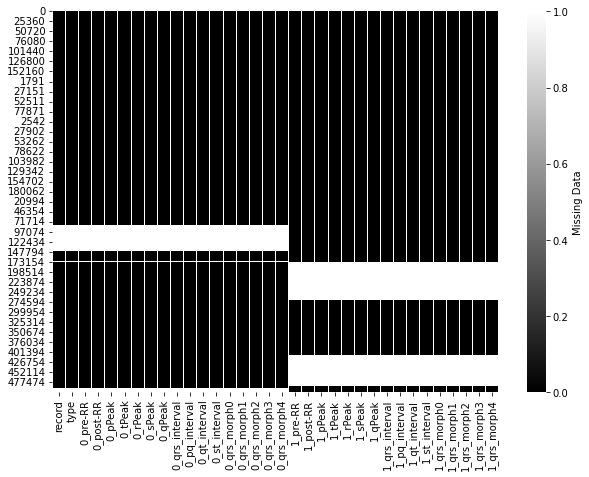

In [9]:
plt.figure(figsize=(10,7))
sns.heatmap(all_data.isna(),
            cmap="binary_r",
            cbar_kws={'label': 'Missing Data'})


Remove null observations from test_data

In [10]:
all_data = all_data.dropna()

Remove 'record' column, because the name of the subject/patient is irrelevant in this study.

In [11]:
all_data = all_data.drop("record", axis=1)

### Train-test split

In [12]:
train_data, test_data = train_test_split(all_data, test_size=0.2, stratify=all_data['type'])

In [13]:
test_data.groupby("type").size()

type
F          251
N       128943
Q           29
SVEB      3700
VEB       9642
dtype: int64

Split X and y

In [14]:
y_train = train_data["type"]
X_train = train_data.drop(columns=["type"])

In [15]:
y_test = test_data["type"]
X_test = test_data.drop(columns=["type"])

### Outliers

Check if outliers influence arrhythmia

In [16]:
print(
    "Q1:",
    train_data["0_pPeak"].quantile(0.25),
    "Q2:",
    train_data["0_pPeak"].quantile(0.5),
    "Q3:",
    train_data["0_pPeak"].quantile(0.75),
)
print("Min:", min(train_data["0_pPeak"]), "Max:", max(train_data["0_pPeak"]))

Q1: -0.032977899 Q2: 0.015048413 Q3: 0.0752941738003408
Min: -4.208600735 Max: 10.56590393


In [17]:
q3 = train_data["0_pPeak"].quantile(0.75)
print("Amount of outliers:", len(train_data.loc[train_data["0_pPeak"] > q3]))
print("Amount of data:", len(train_data))

Amount of outliers: 142564
Amount of data: 570257


In [18]:
print("Percentage of type in the outlier group")
print(train_data.loc[train_data["0_pPeak"] > q3].groupby("type").size() * 100 / len(train_data.loc[train_data["0_pPeak"] > q3]))
print()
print("Percentage of type in the train_data")
print(train_data.groupby("type").size() * 100 / len(train_data))

Percentage of type in the outlier group
type
F        0.287590
N       78.947701
Q        0.064532
SVEB     3.345164
VEB     17.355012
dtype: float64

Percentage of type in the train_data
type
F        0.176061
N       90.444835
Q        0.019991
SVEB     2.595496
VEB      6.763617
dtype: float64


In [19]:
#Jest bardzo dużo outlierów, ale czy powinniśmy je usunąć lub zastąpić? Możliwe, że to były mocniejsze uderzenia serca u zdrowych osób.

#### Visualisation

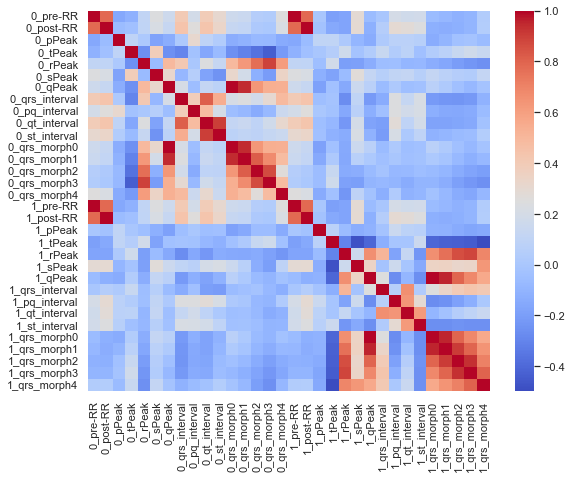

In [20]:
corr_matrix = X_train.corr()
plt.figure(figsize=(9,7))
sns.set_theme("notebook")
sns.set_palette("PuBuGn_d")
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.savefig("images/corplot.png")

In [21]:
train_data0 = train_data[["type", *[column_name for column_name in train_data.columns if column_name.startswith("0_")]]]

In [22]:
train_data1 = train_data[["type", *[column_name for column_name in train_data.columns if column_name.startswith("1_")]]]

Box plots for raw (0) and filtered (1) data divided into groups:
* pre-RR i post-RR
* peaks
* intervals
* morphology

In [23]:
# Zbudowanie wykresów pudełkowych trwa ok. 3 minuty.
# Jeśli nie potrzebujesz wersji interaktywnej, możesz skorzystać z zapisanych obrazów.

def box_plot(t_data, features, name):
    data_to_box = pd.melt(t_data[["type", *features]], id_vars="type", value_vars=features)
    fig_box = px.box(data_to_box, y="value", x="variable", color="type", width=1000)
    fig_box.write_image("images/" + name + ".png")

prepost_0=["0_pre-RR", "0_post-RR"]
box_plot(train_data0, prepost_0, "box_RR_0")

prepost_1=["1_pre-RR", "1_post-RR"]
box_plot(train_data1, prepost_1, "box_RR_1")

peaks_0=["0_pPeak", "0_tPeak", "0_rPeak", "0_sPeak", "0_qPeak"]
box_plot(train_data0, peaks_0, "box_peaks_0")

peaks_1=["1_pPeak", "1_tPeak", "1_rPeak", "1_sPeak", "1_qPeak"]
box_plot(train_data1, peaks_1, "box_peaks_1")

intervals_0=["0_qrs_interval", "0_pq_interval", "0_qt_interval", "0_st_interval"]
box_plot(train_data0, intervals_0, "box_intervals_0")

intervals_1=["1_qrs_interval", "1_pq_interval", "1_qt_interval", "1_st_interval"]
box_plot(train_data1, intervals_1, "box_intervals_1")

morphs_0=["0_qrs_morph0", "0_qrs_morph1", "0_qrs_morph2", "0_qrs_morph3", "0_qrs_morph4"]
box_plot(train_data0, morphs_0, "box_morphs_0")

morphs_1=["1_qrs_morph0", "1_qrs_morph1", "1_qrs_morph2", "1_qrs_morph3", "1_qrs_morph4"]
box_plot(train_data1, morphs_1, "box_morphs_1")

PCA

In [23]:
std_all = StandardScaler()
train_data_std = std_all.fit_transform(X_train)
train_data_std = pd.DataFrame(train_data_std, columns=X_train.columns)

pca = PCA(n_components=2)
components = pca.fit_transform(train_data_std)

fig = px.scatter(components, x=0, y=1, color=y_train, width=800)
fig.write_image("images/pca.png")
# fig.show()

### New variables and its significance

In [24]:
# Na podstawie wykresów pudełkowych box_RR_0 i box_RR_1 można zauważyć, że w przypadku zaburzenia SVEB, preRR jest często krótsze niż postRR,
# dlatego dodano dwie zmienne opisujące ich różnice.
data_new=pd.DataFrame()
data_new["0_RR_diff"] = X_train["0_pre-RR"] - X_train["0_post-RR"]
data_new["1_RR_diff"] = X_train["1_pre-RR"] - X_train["1_post-RR"]
data_new["type"] =  y_train

def perform_dunn_test(data, column, group="type", p_adjust="fdr_bh"):
    dunn_df = posthoc_dunn(data, val_col=column, group_col=group, p_adjust=p_adjust)
    remove = np.tril(np.ones(dunn_df.shape), k=0).astype(bool)
    dunn_df[remove] = np.nan
    molten_df = dunn_df.melt(ignore_index=False).reset_index().dropna()
    molten_df.rename(columns={"value": f"{column}_sign"}, inplace=True)
    return molten_df

molten_df1 = perform_dunn_test(data_new, "0_RR_diff")
molten_df2 = perform_dunn_test(data_new, "1_RR_diff")

dunn_summ = pd.merge(molten_df1, molten_df2)

# wskazanie istotnych
def color_red(val):
    color = "red" if val <= 0.05 else "black"
    return f"color: {color}"

# Stworzenie obiektu Styler i zastosowanie funkcji do kolumny "0_RR_diff"
dunn_summ = dunn_summ.style.applymap(color_red, subset=["0_RR_diff_sign",	"1_RR_diff_sign"])
dunn_summ

,index,variable,0_RR_diff_sign,1_RR_diff_sign
0,F,N,0.010176,0.010176
1,F,Q,0.072438,0.072438
2,N,Q,0.006915,0.006915
3,F,SVEB,0.000000,0.000000
4,N,SVEB,0.000000,0.000000
5,Q,SVEB,0.000000,0.000000
6,F,VEB,0.000000,0.000000
7,N,VEB,0.000000,0.000000
8,Q,VEB,0.000000,0.000000
9,SVEB,VEB,0.000000,0.000000


The above results confirm that the newly created variables significantly differentiate all pairs of types except F and N.

### Pre-processing (for all)

X_train - entire original training data

y_train - training labels for the whole set

X_sample - sample of training data for grid-search

y_sample - training labels for the sample

In [25]:
X_train["0_RR_diff"] = X_train["0_pre-RR"] - X_train["0_post-RR"]
X_train["1_RR_diff"] = X_train["1_pre-RR"] - X_train["1_post-RR"]

X_test["0_RR_diff"] = X_test["0_pre-RR"] - X_test["0_post-RR"]
X_test["1_RR_diff"] = X_test["1_pre-RR"] - X_test["1_post-RR"]

In [26]:
X_train.shape

(570257, 34)

Sampling for grid-search

In [27]:
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, test_size=0.90, stratify=y_train, random_state=42)

In [28]:
y_sample.value_counts()

N       51576
VEB      3857
SVEB     1480
F         100
Q          12
Name: type, dtype: int64

In [29]:
pipe_resample = Pipeline([
    ('oversampler_F', RandomOverSampler(sampling_strategy={'F': 200})),
    ('undersampler_N', RandomUnderSampler(sampling_strategy={'N': 5000})),
    ('oversampler_Q', RandomOverSampler(sampling_strategy={'Q': 100}))
])

X_resampled, y_resampled = pipe_resample.fit_resample(X_sample, y_sample)
y_resampled.value_counts()

N       5000
VEB     3857
SVEB    1480
F        200
Q        100
Name: type, dtype: int64

In [30]:
pipeline= Pipeline(
    [
        ('std_scaler', StandardScaler())
    ]
)
X_train_std = pd.DataFrame(pipeline.fit_transform(X_train), columns=X_train.columns)
X_test_std = pd.DataFrame(pipeline.transform(X_test), columns=X_train.columns)
X_sample_std= pd.DataFrame(pipeline.fit_transform(X_resampled), columns=X_train.columns)

## Data selection

In [31]:
#Komórka w której zmieniam, na jakich danych chcę testować algorytm
X_data_sample= X_resampled #X_sample #lub X_resampled
y_data_sample= y_resampled #y_sample #lub y_resampled 

# X_data_sample=X_train

X_data_train=X_train #lub X_train_std
y_data_train=y_train

X_data_test=X_test #X_test_std
y_data_test=y_test

## Model 1 - Dummy model

A 'dumb' model has been created that will be used for comparisons as to whether our models get better results. A most-frequent strategy was adopted, which will result in all observations being classified as N (normal).

In [32]:
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train.drop(['0_RR_diff', '1_RR_diff'], axis=1), y_train)
y_pred = dummy_model.predict(X_test.drop(['0_RR_diff', '1_RR_diff'], axis=1))
accuracy_assessment(y_test, y_pred)

Accuracy: 0.9044506014800267
Balanced accuracy: 0.2


c:\users\alicj\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Precision: 0.818030890517582
Sensivity (recall): 0.9044506014800267
F1-Score: 0.8590728369450557


## Model 2 - Decision Trees

### STEP 1: Visualisation of the relationship between max_depth and accuracy

Checking on the chart in which range it is worth looking for the optimum tree depth

In [33]:
# drzewo decyzyjne z walidacją krzyżową i zbalansowaniem klas przy podziale na treningowe i testowe

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

ma_train = []
ma_test = []
for j in range(1, 31):
    model = tree.DecisionTreeClassifier(random_state=10, max_depth=j)
    a_test = []
    a_tren = []

    for i, (train_index, test_index) in enumerate(skf.split(X_data_sample, y_data_sample)):
        model.fit(X_data_sample.iloc[train_index], y_data_sample.iloc[train_index])
        a_test.append(model.score(X_data_sample.iloc[test_index], y_data_sample.iloc[test_index]).round(4))
        a_tren.append(model.score(X_data_sample.iloc[train_index], y_data_sample.iloc[train_index]).round(4))

    ma_test.append(np.mean(a_test))
    ma_train.append(np.mean(a_tren))

In [34]:
optimal_depth_tree=np.argmax(ma_test)+1
print("Optimal depth:", optimal_depth_tree)

Optimal depth: 18


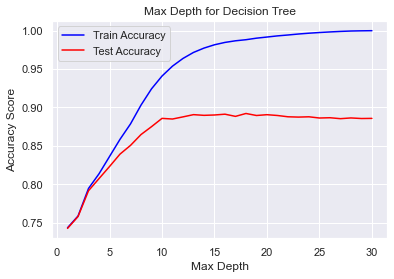

In [35]:
depth = np.arange(1, 31)
train_test_plot(ma_train, ma_test, "Max Depth for Decision Tree", "Max Depth", depth)

### STEP 2: GridSearchCV for Decision Trees

In [36]:
model_dt= tree.DecisionTreeClassifier(random_state=42)

model_dt.fit(X_data_sample, y_data_sample)

trees_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(10,23,2),
    'min_samples_leaf': [1,2,4]
}
 
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
dt_grid_search = GridSearchCV(model_dt, trees_param_grid, cv=cv_strategy, scoring='balanced_accuracy', return_train_score=True)
dt_grid_search.fit(X_data_sample, y_data_sample)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(10, 23, 2),
                         'min_samples_leaf': [1, 2, 4]},
             return_train_score=True, scoring='balanced_accuracy')

In [37]:
tree_results=dt_grid_search.cv_results_

In [38]:
results_df = pd.DataFrame(tree_results)
params_df = pd.json_normalize(results_df['params'])
metrics = ['mean_test_score', 'std_test_score']
tree_results_df = pd.concat([params_df, results_df[metrics]], axis=1)

tree_results_df.columns=["criterion", "max_depth", "min_samples_leaf", "mean_test_score", "std_test_score"]
tree_results_df.sort_values(by='mean_test_score', ascending=False).head(10)

,criterion,max_depth,min_samples_leaf,mean_test_score,std_test_score
36,entropy,20,1,0.880568,0.013775
39,entropy,22,1,0.878618,0.013344
33,entropy,18,1,0.876651,0.014338
30,entropy,16,1,0.875611,0.017876
27,entropy,14,1,0.874892,0.016009
18,gini,22,1,0.873178,0.015285
34,entropy,18,2,0.871648,0.013341
37,entropy,20,2,0.869736,0.016099
40,entropy,22,2,0.869261,0.016006
28,entropy,14,2,0.867315,0.013357


In [39]:
print(len(tree_results_df))

42


In [40]:
y_train.value_counts()

N       515768
VEB      38570
SVEB     14801
F         1004
Q          114
Name: type, dtype: int64

### STEP 3: Building a model on all training data

In [41]:
best_dt_model = dt_grid_search.best_estimator_
best_dt_model.fit(X_data_train, y_data_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)

### STEP 4: Accuracy assessment

In [42]:
y_pred = best_dt_model.predict(X_data_test)
accuracy_assessment(y_data_test, y_pred)

Accuracy: 0.9793076842142181
Balanced accuracy: 0.6846894608042825
Precision: 0.9792616057738875
Sensivity (recall): 0.9793076842142181
F1-Score: 0.9792834407664323


ROC-AUC curve

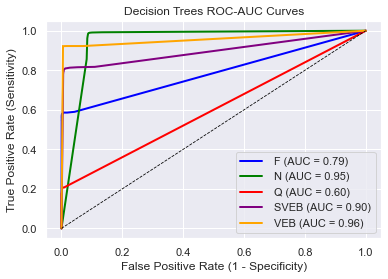

In [43]:
our_roc_curves(X_data_test, y_data_test, best_dt_model, "Decision Trees ROC-AUC Curves")

Confusion matrix

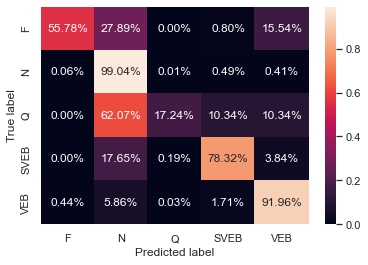

In [44]:
confussion_matrix(y_test, y_pred)

Significant variables

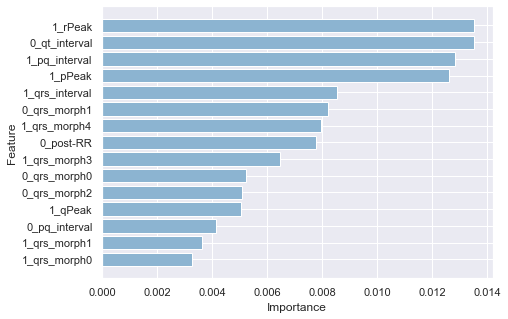

In [45]:
significant_variable(best_dt_model, X_train)

## Model 3 - Random Forest

### STEP 1: Visualisation of the relationship between tree depth and number of trees and accuracy

The visualisation will give an idea of the ranges within which to look for optimal estimators.

In [46]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

ma_train_rf = []
ma_test_rf = []
for j in range(1, 31):
    model = RFmodel = RandomForestClassifier(random_state=10, max_depth=j, n_estimators=10)
    a_test = []
    a_tren = []

    for i, (train_index, test_index) in enumerate(skf.split(X_data_sample, y_data_sample)):
        model.fit(X_data_sample.iloc[train_index], y_data_sample.iloc[train_index])
        a_test.append(model.score(X_data_sample.iloc[test_index], y_data_sample.iloc[test_index]).round(4))
        a_tren.append(model.score(X_data_sample.iloc[train_index], y_data_sample.iloc[train_index]).round(4))

    ma_test_rf.append(np.mean(a_test))
    ma_train_rf.append(np.mean(a_tren))

In [47]:
# Indeks głębokości drzewa, która daje najlepszą średnią dokładność testu
optimal_depth = np.argmax(ma_test_rf) + 1
print("Optimal depth:", optimal_depth)

Optimal depth: 20


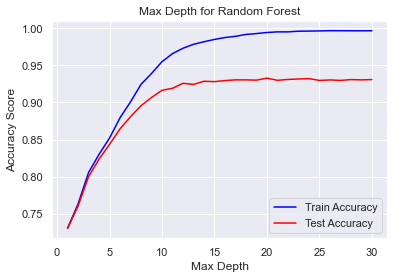

In [48]:
depth = np.arange(1, 31)
train_test_plot(ma_train_rf, ma_test_rf, "Max Depth for Random Forest", "Max Depth", depth)

In [49]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
n_estimators_values = [1,2,3,4,5, 10, 15, 20]
ma_rf_train = []
ma_rf_test = []

for n_estimators in n_estimators_values:
    model = RandomForestClassifier(random_state=10, n_estimators=n_estimators, max_depth=18)
    a_test = []
    a_tren = []
    for i, (train_index, test_index) in enumerate(skf.split(X_data_sample, y_data_sample)):
        model.fit(X_data_sample.iloc[train_index], y_data_sample.iloc[train_index])
        a_test.append(model.score(X_data_sample.iloc[test_index], y_data_sample.iloc[test_index]).round(4))
        a_tren.append(model.score(X_data_sample.iloc[train_index], y_data_sample.iloc[train_index]).round(4))

    ma_rf_test.append(np.mean(a_test))
    ma_rf_train.append(np.mean(a_tren))

optimal_n_estimators = n_estimators_values[np.argmax(ma_rf_test)]
print("Optimal value n_estimators:", optimal_n_estimators)


Optimal value n_estimators: 20


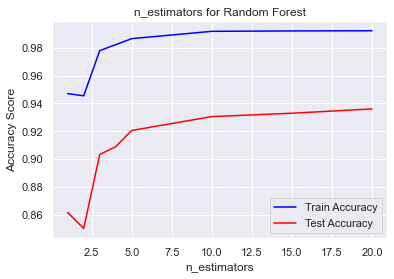

In [50]:
train_test_plot(ma_rf_train, ma_rf_test, "n_estimators for Random Forest", "n_estimators", n_estimators_values)

### STEP 2: GridSearchCV for RandomForest

In [51]:
model_rf=RandomForestClassifier(random_state=42)

rf_param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=15, stop=50, num=10)],
    'max_depth': [int(x) for x in np.linspace(15, 35, num=10)],
    'min_samples_leaf': [1, 2, 4]
}

model_rf.fit(X_data_sample, y_data_sample)

rf_grid_search = RandomizedSearchCV(
    model_rf,
    param_distributions=rf_param_dist,
    n_iter=10,
    cv=5, 
    scoring='balanced_accuracy', 
    random_state=42
)

rf_grid_search.fit(X_data_sample, y_data_sample)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [15, 17, 19, 21, 23, 26,
                                                      28, 30, 32, 35],
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': [15, 18, 22, 26, 30, 34,
                                                         38, 42, 46, 50]},
                   random_state=42, scoring='balanced_accuracy')

In [52]:
rf_results=rf_grid_search.cv_results_

In [53]:
results_df = pd.DataFrame(rf_results)
params_df = pd.json_normalize(results_df['params'])
metrics = ['mean_test_score', 'std_test_score']
rf_results_df = pd.concat([params_df, results_df[metrics]], axis=1)
rf_results_df.sort_values(by='mean_test_score', ascending=False).head(10)

,n_estimators,min_samples_leaf,max_depth,mean_test_score,std_test_score
2,22,1,26,0.922033,0.019604
5,38,2,30,0.911797,0.019548
6,38,2,28,0.911305,0.019192
7,50,2,21,0.905604,0.018777
8,34,1,15,0.900764,0.020743
3,50,1,15,0.898886,0.020346
1,38,4,32,0.880107,0.021184
9,34,4,26,0.879663,0.021511
0,26,4,28,0.873885,0.018424
4,26,4,30,0.873770,0.018612


### STEP 3: Building a model on all training data

In [54]:
best_rf_model = rf_grid_search.best_estimator_
best_rf_model.fit(X_data_train, y_data_train)

RandomForestClassifier(max_depth=26, n_estimators=22, random_state=42)

### STEP 4: Accuracy assessment

In [55]:
y_pred = best_rf_model.predict(X_data_test)
accuracy_assessment(y_data_test, y_pred)

Accuracy: 0.9856977519026409
Balanced accuracy: 0.655808177615191
Precision: 0.9852954188364844
Sensivity (recall): 0.9856977519026409
F1-Score: 0.9851251677583864


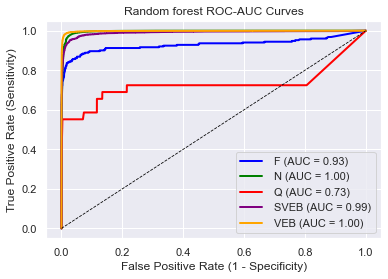

In [56]:
our_roc_curves(X_data_test, y_data_test, best_rf_model, "Random forest ROC-AUC Curves")

Confusion matrix

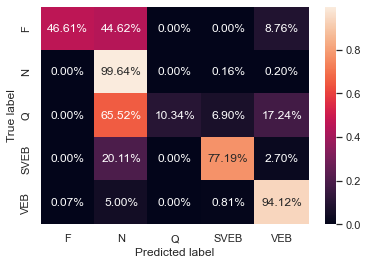

In [57]:
confussion_matrix(y_data_test, y_pred)

Significant variables

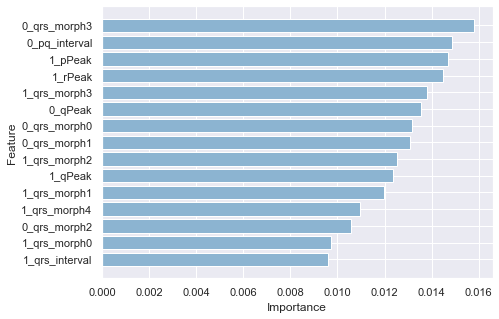

In [58]:
significant_variable(best_rf_model, X_train)

## Model 4 - K-Nearest Neighbors Classification

### STEP 1: Visualisation of the relationship between k-value and accuracy

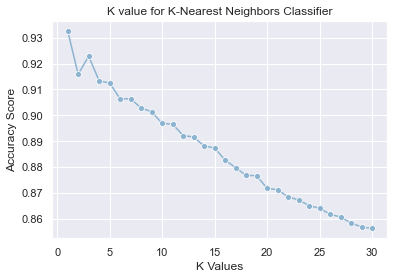

In [72]:
k_values = [i for i in range (1,31)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_sample_std.values, y_data_sample, cv=5)
    scores.append(np.mean(score))

sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
plt.title("K value for K-Nearest Neighbors Classifier")
plt.show()

### STEP 2: GridSearchCV for KNN

In [73]:
warnings.filterwarnings('ignore')

knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': (1, 10, 1),
    'leaf_size': (10, 20, 1),
    'weights': ('uniform', 'distance'),
}
knn_grid = GridSearchCV(knn, param_grid, cv=10, scoring='balanced_accuracy', return_train_score=False)
knn_grid.fit(X_sample_std.values, y_data_sample)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': (10, 20, 1), 'n_neighbors': (1, 10, 1),
                         'weights': ('uniform', 'distance')},
             scoring='balanced_accuracy')

In [74]:
warnings.filterwarnings('default')

In [75]:
knn_grid.best_params_

c:\users\alicj\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



{'leaf_size': 10, 'n_neighbors': 1, 'weights': 'uniform'}

### STEP 3: Building a model on all training data

In [76]:
best = knn_grid.best_estimator_
best.fit(X_train_std.values, y_data_train)

KNeighborsClassifier(leaf_size=10, n_neighbors=1)

### STEP 4: Accuracy assessment

In [77]:
y_pred = best.predict(X_test_std.values)

c:\users\alicj\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [78]:
accuracy_assessment(y_data_test, y_pred)

c:\users\alicj\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Accuracy: 0.9864833584680672
Balanced accuracy: 0.7495042320280227
Precision: 0.9862709396209415
Sensivity (recall): 0.9864833584680672
F1-Score: 0.9863657791750807


c:\users\alicj\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



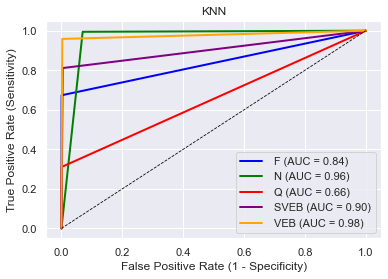

In [79]:
our_roc_curves(X_test_std.values, y_data_test, best, "KNN ROC-AUC Curves")

c:\users\alicj\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



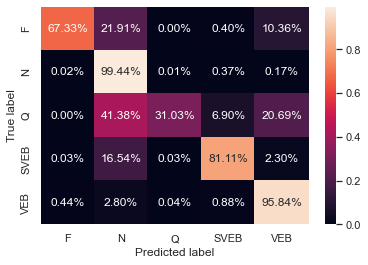

In [80]:
confussion_matrix(y_data_test, y_pred)

## Voting Classifier